In [1]:
!pip install tensorflow==2.7.0

!pip install tensorflow-addons==0.13.0

!pip install keras==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 270.4 kB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
      Successfull

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
# Definir el generador de imágenes de entrenamiento con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Definir el generador de imágenes de validación sin aumento de datos
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
valid_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Cargar un modelo pre-entrenado y ajustar las últimas capas para el conjunto de datos actual
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),
    weights='imagenet',
    pooling='avg'
)

x = base_model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94674944/94668760 [==============================] - 3s 0us/step


In [6]:
# Congelar las capas del modelo pre-entrenado para evitar que se modifiquen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Definir callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)

In [8]:
# Compilar el modelo
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Entrenar el modelo
history = model.fit(
train_generator,
epochs=20,
steps_per_epoch=len(train_generator),
validation_data=valid_generator,
validation_steps=len(valid_generator),
callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
163/163 [==============================] - 162s 953ms/step - loss: 0.3073 - accuracy: 0.8664 - val_loss: 0.2994 - val_accuracy: 0.8910

Epoch 00001: val_loss improved from inf to 0.29942, saving model to best_model.h5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
163/163 [==============================] - 123s 754ms/step - loss: 0.1932 - accuracy: 0.9231 - val_loss: 0.2713 - val_accuracy: 0.8974

Epoch 00002: val_loss improved from 0.29942 to 0.27129, saving model to best_model.h5
Epoch 3/20
163/163 [==============================] - 123s 755ms/step - loss: 0.1702 - accuracy: 0.9294 - val_loss: 0.2673 - val_accuracy: 0.8942

Epoch 00003: val_loss improved from 0.27129 to 0.26726, saving model to best_model.h5
Epoch 4/20
163/163 [==============================] - 123s 754ms/step - loss: 0.1578 - accuracy: 0.9348 - val_loss: 0.2710 - val_accuracy: 0.9022

Epoch 00004: val_loss did not improve from 0.26726
Epoch 5/20
163/163 [==============================] - 123s 752ms/step - loss: 0.1469 - accuracy: 0.9429 - val_loss: 0.2479 - val_accuracy: 0.9167

Epoch 00005: val_loss improved from 0.26726 to 0.24786, saving model to best_model.h5
Epoch 6/20
163/163 [==============================] - 123s 757ms/step - loss: 0.1410 - accuracy: 0.9463

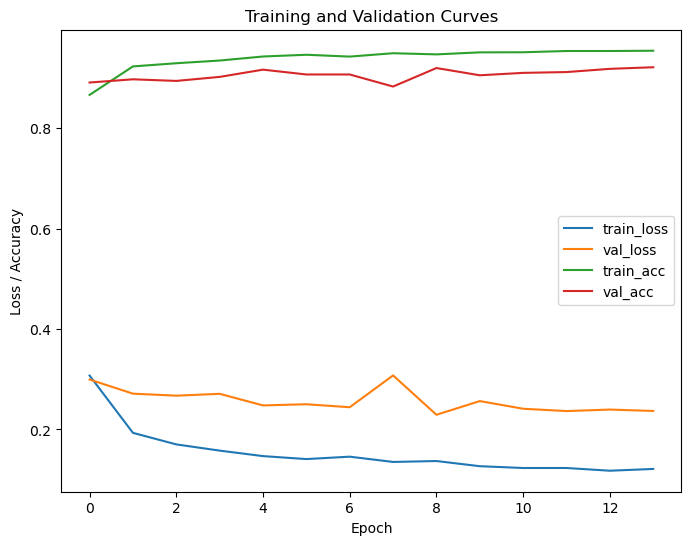

In [10]:
#Graficar la curva de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Curves')
plt.show()

In [11]:
# Evaluar el modelo en el conjunto de prueba
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(224, 224),
batch_size=32,
class_mode="binary",
shuffle=False
)

model.evaluate(test_generator)

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 250ms/step - loss: 0.2818 - accuracy: 0.9375


[0.28184646368026733, 0.9375]

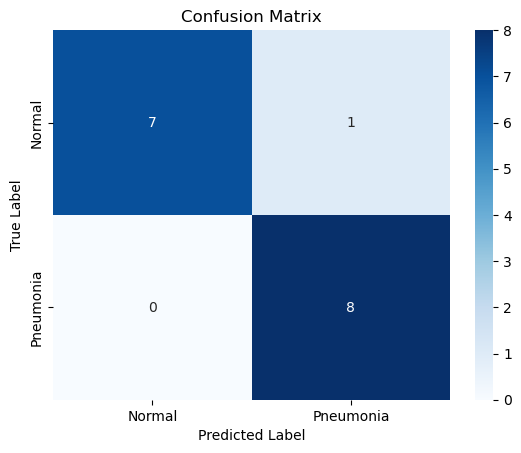

In [12]:
# Predecir las etiquetas para el conjunto de prueba y generar una matriz de confusión
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Mostrar el informe de clasificación
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.88      0.93         8
   Pneumonia       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

